<a href="https://colab.research.google.com/github/danielperebinos/Deep-Learning/blob/main/Gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
from torch.cuda import is_available
import copy
import re
import unicodedata

import pandas as pd

import torch
torch.manual_seed(57)
from torch import nn
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer

import matplotlib.pyplot as plt
import json

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv('drive/MyDrive/Datasets/NationalNames.csv')
df

,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746
...,...,...,...,...,...
1825428,1825429,Zykeem,2014,M,5
1825429,1825430,Zymeer,2014,M,5
1825430,1825431,Zymiere,2014,M,5
1825431,1825432,Zyran,2014,M,5


In [ ]:
df.drop(columns = ['Count', 'Id', 'Year'], inplace=True)

In [ ]:
df

,Name,Gender
0,Mary,F
1,Anna,F
2,Emma,F
3,Elizabeth,F
4,Minnie,F
...,...,...
1825428,Zykeem,M
1825429,Zymeer,M
1825430,Zymiere,M
1825431,Zyran,M


In [ ]:
df.Gender.value_counts()

F    1081683
M     743750
Name: Gender, dtype: int64

In [ ]:
label2index = {'F':0, 'M':1}
index2label = {0:'Female', 1:'Male'}

df.Gender = df.Gender.apply(lambda x:label2index[x])
df

,Name,Gender
0,Mary,0
1,Anna,0
2,Emma,0
3,Elizabeth,0
4,Minnie,0
...,...,...
1825428,Zykeem,1
1825429,Zymeer,1
1825430,Zymiere,1
1825431,Zyran,1


In [ ]:
df.Gender.value_counts()

0    1081683
1     743750
Name: Gender, dtype: int64

In [ ]:
df.Name = df.Name.apply(lambda x:x.lower())
df

,Name,Gender
0,mary,0
1,anna,0
2,emma,0
3,elizabeth,0
4,minnie,0
...,...,...
1825428,zykeem,1
1825429,zymeer,1
1825430,zymiere,1
1825431,zyran,1


In [ ]:
def unicodeToAscii(string):
  return ''.join(
      char for char in unicodedata.normalize('NFD', string)
      if unicodedata.category(char) != 'Mn'
  )

def normalizeString(string):
  string = unicodeToAscii(string.lower()).strip()
  string = re.sub(r'([.!?])', r' \1', string)
  string = re.sub(r'[^a-zA-Z]+', r' ', string)
  string = re.sub(r'\s+', r' ', string).strip()
  return string

In [ ]:
class NameVocabulary:
  def __init__(self):
    self.PAD_TOKEN = 0
    self.max_length = 50
    letters = [chr(letter) for letter in range(ord('a'),ord('z')+1)]
    self.letter2index = {}
    self.index2letter = {}
    for index in range(len(letters)):
      self.letter2index[letters[index]] = index + 1
      self.index2letter[index+1] = letters[index]
  
  def name2indexes(self, name:str):
    
    if len(name) > self.max_length: self.max_length = len(name) 
    indexes = [0 for _ in range(self.max_length)]
    for index in range(len(name)):
      indexes[index] = self.letter2index[name[index]]
    return indexes
  
  def indexes2name(self, indexes):
    return ''.join([self.index2letter[index] for index in indexes])

In [ ]:
vocabulary = NameVocabulary()

In [ ]:
df['indexes'] = df['Name'].apply(lambda x: vocabulary.name2indexes(x))
df

,Name,Gender,indexes
0,mary,0,"[13, 1, 18, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,anna,0,"[1, 14, 14, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,emma,0,"[5, 13, 13, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,elizabeth,0,"[5, 12, 9, 26, 1, 2, 5, 20, 8, 0, 0, 0, 0, 0, ..."
4,minnie,0,"[13, 9, 14, 14, 9, 5, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1825428,zykeem,1,"[26, 25, 11, 5, 5, 13, 0, 0, 0, 0, 0, 0, 0, 0,..."
1825429,zymeer,1,"[26, 25, 13, 5, 5, 18, 0, 0, 0, 0, 0, 0, 0, 0,..."
1825430,zymiere,1,"[26, 25, 13, 9, 5, 18, 5, 0, 0, 0, 0, 0, 0, 0,..."
1825431,zyran,1,"[26, 25, 18, 1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
class Dataset():
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    return torch.tensor(self.df.indexes.iloc[index]), torch.tensor(self.df.Gender.iloc[index])

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
train

,Name,Gender,indexes
564844,leonarda,0,"[12, 5, 15, 14, 1, 18, 4, 1, 0, 0, 0, 0, 0, 0,..."
1247418,sadrac,1,"[19, 1, 4, 18, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
832348,rashema,0,"[18, 1, 19, 8, 5, 13, 1, 0, 0, 0, 0, 0, 0, 0, ..."
220604,andrea,1,"[1, 14, 4, 18, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
387614,genora,0,"[7, 5, 14, 15, 18, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
259178,elizebath,0,"[5, 12, 9, 26, 5, 2, 1, 20, 8, 0, 0, 0, 0, 0, ..."
1414414,tarell,1,"[20, 1, 18, 5, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0,..."
131932,bonna,0,"[2, 15, 14, 14, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
671155,cheryle,0,"[3, 8, 5, 18, 25, 12, 5, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
train_dataset = Dataset(train)
test_dataset = Dataset(test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 512, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 512, shuffle = True)

In [ ]:
class GRU(nn.Module):
  def __init__(self, hidden_dim, output_dim, n_layers, num_words, drop_prob = 0.2):
    super().__init__()
    self.embedding = nn.Embedding(num_words, hidden_dim)
    self.gru = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first = True, dropout = drop_prob)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.ReLU = nn.ReLU()

  def forward(self, x):
    x = self.embedding(x)
    out, h = self.gru(x)
    out = self.fc(self.ReLU(out[:, -1]))
    return out

In [ ]:
model = GRU(num_words=vocabulary.max_length, hidden_dim=128, output_dim=2, n_layers=2)
model = model.to(device)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def training_loop(n_epochs, model, optim, loss_fn, train_loader, test_loader):
  train_accuracy = torch.zeros(n_epochs)
  test_accuracy = torch.zeros(n_epochs)

  for epoch in range(n_epochs):
    model.train()
    for examples, labels in train_loader:
      examples = examples.to(device)
      labels = labels.to(device)

      outputs = model(examples)
      loss = loss_fn(outputs, labels)

      optim.zero_grad()
      loss.backward()
      optim.step()


    model.eval()
    for loader, accuracy in [
          (train_loader, train_accuracy),
          (test_loader, test_accuracy)
    ]:

      correct = 0
      total = 0

      with torch.no_grad():
        for examples, labels in loader:
          examples = examples.to(device)
          labels = labels.to(device)

          outputs = model(examples)
          _, predicted = torch.max(outputs, dim=1)

          total += labels.shape[0]
          correct += int((predicted == labels).sum())
      
      accuracy[epoch] = correct/total
  
    best_test_accuracy = (epoch == test_accuracy.max(dim=0)[1]).item()
    if best_test_accuracy:
      best_model = copy.deepcopy(model.state_dict())
  

    print(f'Epoch {epoch + 1}',
          f'Train Accuracy: {train_accuracy[epoch]}',
          f'Test Accuracy: {test_accuracy[epoch]}')

  plt.figure(dpi = 150)
  plt.xlabel('number of Epochs')
  plt.ylabel('Accuracy')
  plt.plot(range(1, n_epochs+1), train_accuracy)
  plt.plot(range(1, n_epochs+1), test_accuracy)
  plt.legend(['Train_accuracy', 'Test_accuracy'])
  plt.grid()
  plt.show()

  return best_model

In [ ]:
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

Epoch 1 Train Accuracy: 0.8744602799415588 Test Accuracy: 0.8725562691688538
Epoch 2 Train Accuracy: 0.8852053284645081 Test Accuracy: 0.882515549659729
Epoch 3 Train Accuracy: 0.8889304399490356 Test Accuracy: 0.8853386640548706
Epoch 4 Train Accuracy: 0.8911545872688293 Test Accuracy: 0.8876631855964661
Epoch 5 Train Accuracy: 0.8941370248794556 Test Accuracy: 0.8903219103813171
Epoch 6 Train Accuracy: 0.8948390483856201 Test Accuracy: 0.891194760799408
Epoch 7 Train Accuracy: 0.8959378004074097 Test Accuracy: 0.8914139270782471
Epoch 8 Train Accuracy: 0.8964151740074158 Test Accuracy: 0.892179012298584
Epoch 9 Train Accuracy: 0.8972439169883728 Test Accuracy: 0.8927889466285706
Epoch 10 Train Accuracy: 0.8965927958488464 Test Accuracy: 0.8925077319145203


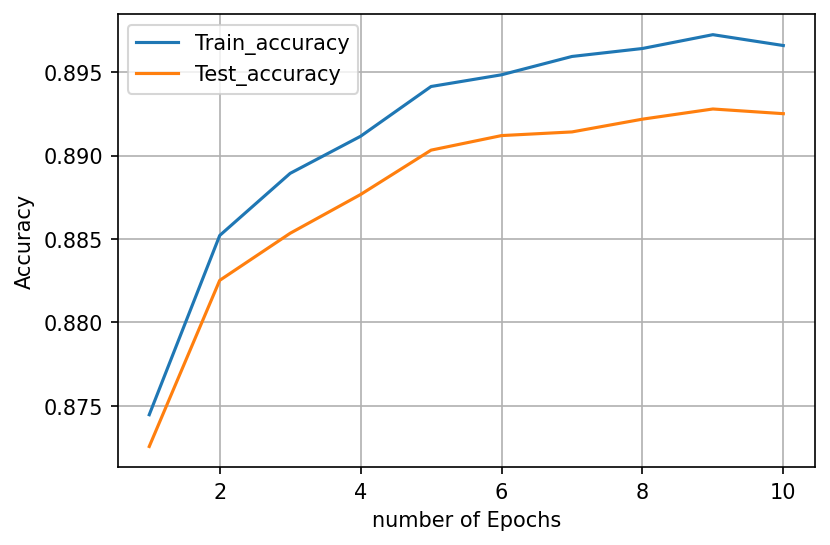

In [ ]:
best_model = training_loop(
    10,
    model,
    optim,
    loss_fn,
    train_loader,
    test_loader
)

In [ ]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

y_test = torch.zeros(len(test))
y_pred = torch.zeros(len(test))
low = 0

model.eval()
with torch.no_grad():
  for examples, labels in test_loader:
    examples = examples.to(device)
    labels = labels.to(device)

    outputs = model(examples)
    _, predicted = torch.max(outputs, dim=1)

    high = low + labels.shape[0]
    y_test[low : high] = labels
    y_pred[low : high] = predicted
    low = high

    total += labels.shape[0]
    correct += int((predicted == labels).sum())

accuracy = correct / total
accuracy

0.8927889268301591

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Text(0.5, 32.08333333333333, 'Predicted Label')

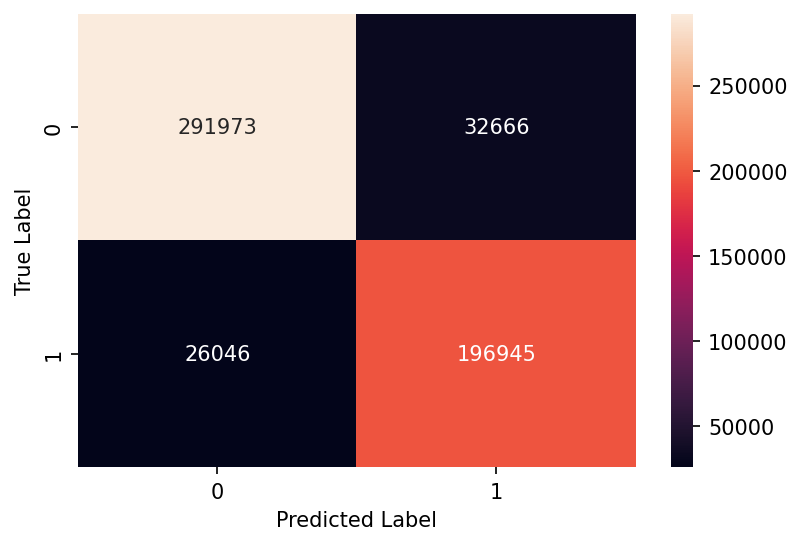

In [ ]:
plt.figure(dpi = 150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/Data/Gender_gpu.pth')

In [ ]:
model.to('cpu')

GRU(
  (embedding): Embedding(50, 128)
  (gru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (ReLU): ReLU()
)

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/Data/Gender_cpu.pth')

In [ ]:
vocabulary.max_length

50

In [ ]:
s = 'salut'
s.removeprefix('su')
s

AttributeError: ignored